In [42]:
import os
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from keras.utils import to_categorical
from keras.layers import *
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

### Data Preparation

In [91]:
p = Path("Dataset")
dirs = p.glob("*")
 
imagesData = []
labels = []

labelsDict = {} #{"Pikachu":0,"Bulbasaur":1,"Meowth":2}
#label2Pokemon = {0:"Pikachu",1:"Bulbasaur",2:"Meowth"}
idx = 0
for folders in dirs:
    label = str(folders).split("\\")[-1]
    cnt = 0
    print(label)
    labelsDict[label] = idx
    for imagePath in folders.glob("*.jpg"):
        img = image.load_img(imagePath,target_size=(40,40))
        imgArr = image.img_to_array(img)
        imagesData.append(imgArr)
        labels.append(labelsDict[label])
        cnt += 1
    print(cnt)
    idx += 1
print(labelsDict)

Abra
41
Aerodactyl
97
Alakazam
48
Arbok
63
Arcanine
61
Articuno
56
Beedrill
53
Bellsprout
55
Blastoise
61
Bulbasaur
176
Butterfree
66
Caterpie
49
Chansey
57
Charizard
52
Charmander
200
Charmeleon
65
Clefable
49
Clefairy
59
Cloyster
59
Cubone
58
Dewgong
66
Diglett
51
Ditto
48
Dodrio
65
Doduo
48
Dragonair
65
Dragonite
62
Dratini
107
Drowzee
60
Dugtrio
64
Eevee
41
Ekans
51
Electabuzz
53
Electrode
67
Exeggcute
57
Exeggutor
67
Farfetchd
64
Fearow
122
Flareon
59
Gastly
50
Gengar
60
Geodude
56
Gloom
58
Golbat
67
Goldeen
58
Golduck
60
Golem
64
Graveler
57
Grimer
64
Growlithe
68
Gyarados
67
Haunter
63
Hitmonchan
61
Hitmonlee
65
Horsea
63
Hypno
62
Ivysaur
53
Jigglypuff
64
Jolteon
64
Jynx
58
Kabuto
56
Kabutops
65
Kadabra
60
Kakuna
67
Kangaskhan
62
Kingler
68
Koffing
65
Krabby
64
Lapras
71
Lickitung
67
Machamp
71
Machoke
51
Machop
53
Magikarp
59
Magmar
59
Magnemite
60
Magneton
58
Mankey
71
Marowak
70
Meowth
70
Metapod
65
Mew
67
Mewtwo
192
Moltres
62
MrMime
58
Muk
70
Nidoking
68
Nidoqueen
65
Nidora

In [93]:
label2Pokemon = dict([value,key] for (key,value) in labelsDict.items())
X = np.array(imagesData)
Y = np.array(labels)

X,Y = shuffle(X,Y,random_state = 2)
X = X/255.0
print(X.shape,Y.shape)

(10120, 40, 40, 3) (10120,)


In [112]:
def drawImg(img,label,i):
    plt.subplot(3,3,i+1)
    plt.title(label2Pokemon[label])
    plt.imshow(img)
    plt.axis("off")

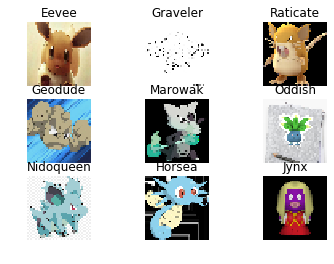

In [113]:
for i in range(9):
    r = np.random.randint(400)
    drawImg(X[r],Y[r],i)

### Spliting Data into Train and Test

In [114]:
split = int(X.shape[0]*.8)

X = np.array(X)
Y = np.array(Y)

XTrain = X[:split,:]
YTrain = Y[:split]

XTest = X[split:,:]
YTest = Y[split:]

print(XTrain.shape,YTrain.shape)
print(XTest.shape,YTest.shape)


(8096, 40, 40, 3) (8096,)
(2024, 40, 40, 3) (2024,)


### Training MLP model

In [91]:
class NeuralNetwork:
    
    def __init__(self,inputSize,layers,outputSize):
        np.random.seed(0)
        
        model = {}
        
        model['W1'] = np.random.randn(inputSize,layers[0])
        model['b1'] = np.zeros((1,layers[0]))
        
        model['W2'] = np.random.randn(layers[0],layers[1])
        model['b2'] = np.zeros((1,layers[1]))
        
        model['W3'] = np.random.randn(layers[1],outputSize)
        model['b3'] = np.zeros((1,outputSize))
        
        self.model = model
        self.activations = None
    
    def forward(self,x):
        
        w1,w2,w3 = self.model['W1'],self.model['W2'],self.model['W3']
        b1,b2,b3 = self.model['b1'],self.model['b2'],self.model['b3']
        
        z1 = np.dot(x,w1) + b1
        a1 = np.tanh(z1)
        
        z2 = np.dot(a1,w2) + b2
        a2 = np.tanh(z2)
        
        z3 = np.dot(a2,w3) + b3
        yPred = softmax(z3)
        
        self.activations = (a1,a2,yPred) 
        return yPred
    
    def backword(self,x,y,learningRate = 0.0001):
        
        w1,w2,w3 = self.model['W1'],self.model['W2'],self.model['W3']
        b1,b2,b3 = self.model['b1'],self.model['b2'],self.model['b3']
        m = x.shape[0]
        
        a1,a2,yPred = self.activations
        
        delta3 = yPred - y
        dw3 = np.dot(a2.T,delta3)
        db3 = np.sum(delta3,axis = 0)
        
        delta2 = (1 - np.square(a2))*np.dot(delta3,w3.T)
        dw2 = np.dot(a1.T,delta2)
        db2 = np.sum(delta2,axis = 0)
        
        delta1 = (1 - np.square(a1))*np.dot(delta2,w2.T)
        dw1 = np.dot(x.T,delta1)
        db1 = np.sum(delta1,axis = 0)
        
        #Updating parameters using Gradient Descent
        self.model['W1'] -= learningRate*dw1
        self.model['b1'] -= learningRate*db1
        
        self.model['W2'] -= learningRate*dw2
        self.model['b2'] -= learningRate*db2
        
        self.model['W3'] -= learningRate*dw3
        self.model['b3'] -= learningRate*db3
        
    def predict(self,x):
        yOut = self.forward(x)
        return np.argmax(yOut,axis = 1)
    
    def summary(self):
        w1,w2,w3 = self.model['W1'],self.model['W2'],self.model['W3']
        a1,a2,yPred = self.activations
        
        print('W1 ',W1.shape)
        print('A1',a1.shape)
        print('W2 ',W2.shape)
        print('A2',a2.shape)
        print('W3 ',W3.shape)
        print('YPred',yPred.shape) 

def softmax(a):
    exA = np.exp(a)
    ans = exA/np.sum(exA,axis = 1,keepdims=True)
    return ans

In [92]:
def loss(yOneHot,p):
    l = -np.mean(yOneHot*np.log(p))
    return l

def oneHot(y,classes):
    m = y.shape[0]
    yOH = np.zeros((m,classes))
    yOH[np.arange(m),y] = 1
    return yOH

In [109]:
def train(X,Y,model,epochs,learningRate,logs = True):
    trainingLoss = []
    
    nOfClasses = len(np.unique(Y))
    
    yOH = oneHot(Y,nOfClasses)
    
    for i in range(epochs):
        yPred = model.forward(X)
        l = loss(yOH,yPred)
        trainingLoss.append(l)
        model.backword(X,yOH,learningRate)
        if(logs and i%50 == 0):
            print("Epoch %d loss is %.4f"%(i,l))
        
    return trainingLoss

In [114]:
model = NeuralNetwork(inputSize = 4800,layers=[100,50],outputSize = 3)

In [115]:
XTrain = XTrain.reshape(XTrain.shape[0],-1)
print(XTrain.shape)

XTest = XTest.reshape(XTest.shape[0],-1)
print(XTest.shape)

(353, 4800)
(89, 4800)


In [116]:
loss = train(XTrain,YTrain,model,500,0.0002)

Epoch 0 loss is 3.2316
Epoch 50 loss is 0.2902
Epoch 100 loss is 0.1460
Epoch 150 loss is 0.1018
Epoch 200 loss is 0.0796
Epoch 250 loss is 0.0626
Epoch 300 loss is 0.0528
Epoch 350 loss is 0.0457
Epoch 400 loss is 0.0401
Epoch 450 loss is 0.0357


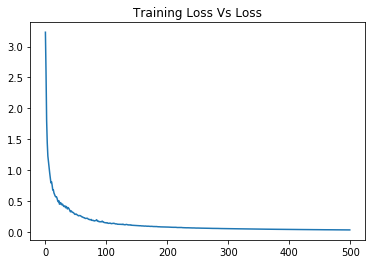

In [118]:
plt.title("Training Loss Vs Loss")
plt.plot(loss)
plt.show()

### Accuracy & Confusion Matrix (tested on small part of dataset)

In [68]:
def getAccuracy(X,Y,model):
    outputs = model.predict(X)
    acc = np.sum(outputs==Y)/Y.shape[0]
    return acc

In [130]:
print("Training Accuracy %.4f"%getAccuracy(XTrain,YTrain,model))
print("Test Accuracy %.4f"%getAccuracy(XTest,YTest,model))

Training Accuracy 0.9802
Test Accuracy 0.5618


In [79]:
"""Use this method directly - """
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

### Predicting and calculating Accuracy

In [142]:
outputsTrain = model.predict(XTrain)
cnfTrain = confusion_matrix(outputsTrain,YTrain)

Confusion matrix, without normalization
[[160   1   3]
 [  0 131   2]
 [  1   0  55]]


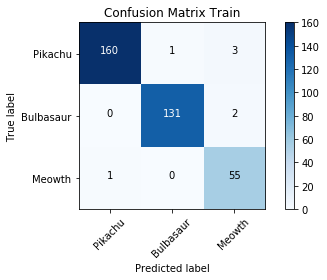

In [146]:
plot_confusion_matrix(cnfTrain,classes=["Pikachu","Bulbasaur","Meowth"],title="Confusion Matrix Train")

In [150]:
print(classification_report(outputsTrain,YTrain))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       164
           1       0.99      0.98      0.99       133
           2       0.92      0.98      0.95        56

   micro avg       0.98      0.98      0.98       353
   macro avg       0.97      0.98      0.97       353
weighted avg       0.98      0.98      0.98       353



#### Confusion Matrix for Test Data

In [148]:
outputsTest = model.predict(XTest)
cnfTest = confusion_matrix(outputsTest,YTest)

Confusion matrix, without normalization
[[21  7  5]
 [10 28  4]
 [ 7  6  1]]


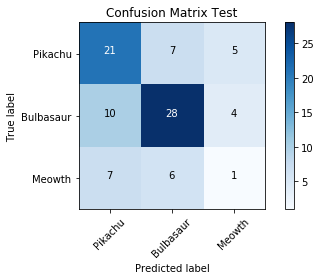

In [149]:
plot_confusion_matrix(cnfTest,classes=["Pikachu","Bulbasaur","Meowth"],title="Confusion Matrix Test")

In [151]:
print(classification_report(outputsTest,YTest))

              precision    recall  f1-score   support

           0       0.55      0.64      0.59        33
           1       0.68      0.67      0.67        42
           2       0.10      0.07      0.08        14

   micro avg       0.56      0.56      0.56        89
   macro avg       0.45      0.46      0.45        89
weighted avg       0.54      0.56      0.55        89



#### F1-Score = 56%

### Visualise Misclassifications

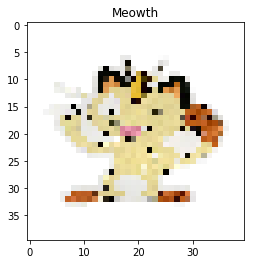

Prediction =  51 Bulbasaur


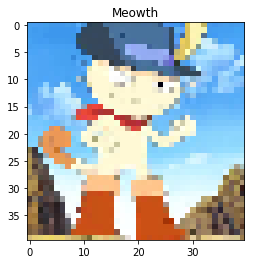

Prediction =  171 Pikachu


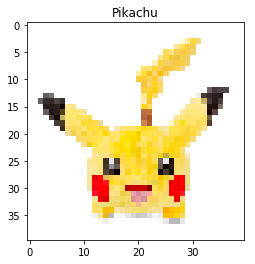

Prediction =  176 Meowth


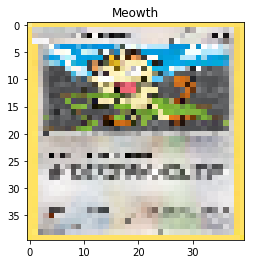

Prediction =  199 Pikachu


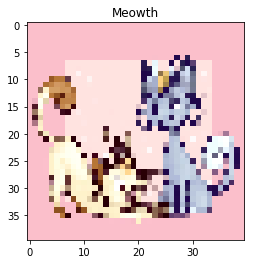

Prediction =  263 Pikachu


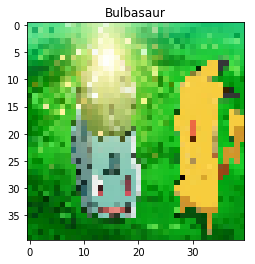

Prediction =  310 Pikachu


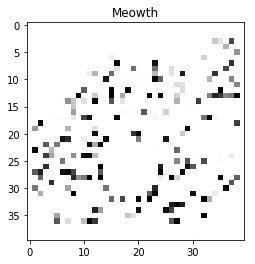

Prediction =  351 Bulbasaur


In [152]:
for i in range(YTrain.shape[0]):
    if YTrain[i] != outputsTrain[i]:
        drawImg(XTrain[i].reshape(40,40,3),YTrain[i])
        print("Prediction =  %d %s"%(i,label2Pokemon[outputsTrain[i]]))

### Improving Accuracy and avoiding misclassifications by using CNN (for whole dataset)

In [115]:
print(XTrain.shape,YTrain.shape)
print(XTest.shape,YTest.shape)

(8096, 40, 40, 3) (8096,)
(2024, 40, 40, 3) (2024,)


In [116]:
YTrainNew = to_categorical(YTrain)
YTestNew = to_categorical(YTest)

In [117]:
print(YTrainNew.shape,YTestNew.shape)

(8096, 151) (2024, 151)


### Training CNN Model

In [139]:
#early stopping is used to prevent overfitting i.e trainig is stopped as soon as we get the best accuracy or least loss
earlyStopping = EarlyStopping(min_delta = 0.001,monitor='val_acc', patience = 5)
callback = [earlyStopping]

#checkpoint to store the best fit model
checkpoint = ModelCheckpoint("best_model.h5",monitor='val_loss',verbose=True,save_best_only=True)

modelCNN = Sequential()
modelCNN.add(Conv2D(64,(3,3),activation='relu',input_shape=(40,40,3)))
modelCNN.add(MaxPool2D((2,2)))
modelCNN.add(Conv2D(128,(3,3),activation='relu'))
modelCNN.add(MaxPool2D((2,2)))
modelCNN.add(Conv2D(256,(3,3),activation='relu'))
modelCNN.add(MaxPool2D((2,2)))
modelCNN.add(Dropout(0.4))
modelCNN.add(Flatten())
modelCNN.add(Dense(512,activation='relu'))
modelCNN.add(Dense(256,activation='relu'))
modelCNN.add(Dense(151,activation='softmax'))
modelCNN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 38, 38, 64)        1792      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 19, 19, 64)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 17, 17, 128)       73856     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 6, 6, 256)         295168    
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 3, 3, 256)         0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 3, 3, 256)         0         
__________

In [140]:
modelCNN.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])

In [141]:
hist = modelCNN.fit(XTrain,YTrainNew,batch_size=32,epochs=100,shuffle=True,validation_split=0.2,callbacks=[checkpoint,earlyStopping])

Train on 6476 samples, validate on 1620 samples
Epoch 1/100
6476/6476 [==============================] - 79s 12ms/step - loss: 4.8816 - acc: 0.0290 - val_loss: 4.6513 - val_acc: 0.0420

Epoch 00001: val_loss improved from inf to 4.65126, saving model to best_model.h5
Epoch 2/100
6476/6476 [==============================] - 77s 12ms/step - loss: 4.5448 - acc: 0.0593 - val_loss: 4.4042 - val_acc: 0.0778

Epoch 00002: val_loss improved from 4.65126 to 4.40416, saving model to best_model.h5
Epoch 3/100
6476/6476 [==============================] - 77s 12ms/step - loss: 4.1546 - acc: 0.1028 - val_loss: 3.9831 - val_acc: 0.1198

Epoch 00003: val_loss improved from 4.40416 to 3.98308, saving model to best_model.h5
Epoch 4/100
6476/6476 [==============================] - 76s 12ms/step - loss: 3.8155 - acc: 0.1397 - val_loss: 3.7679 - val_acc: 0.1617

Epoch 00004: val_loss improved from 3.98308 to 3.76787, saving model to best_model.h5
Epoch 5/100
6476/6476 [==============================] - 78s

### Predicting & Evaluating

In [130]:
def getAccuracyCNN(X,Y,model):
    outputs = model.predict_classes(X)
    acc = np.sum(outputs==Y)/Y.shape[0]
    return acc

##### With Overfitting

In [142]:
#modelCNN.load_weights('best_model.h5')
print(modelCNN.evaluate(XTest,YTestNew))
print(modelCNN.evaluate(XTrain,YTrainNew))

2024/2024 [==============================] - 4s 2ms/step
[5.404731439507526, 0.299901185770751]
8096/8096 [==============================] - 17s 2ms/step
[1.1554239383298652, 0.8349802371541502]


In [143]:
print("Training Accuracy : ", getAccuracyCNN(XTrain,YTrain,modelCNN).round(4)*100,'%')
print("Test Accuracy : " , getAccuracyCNN(XTest,YTest,modelCNN).round(4)*100,'%')

Training Accuracy :  83.5 %
Test Accuracy :  29.99 %


#### WIthout Overfitting

In [147]:
modelCNN.load_weights('best_model.h5')
print(modelCNN.evaluate(XTest,YTestNew))
print(modelCNN.evaluate(XTrain,YTrainNew))

2024/2024 [==============================] - 4s 2ms/step
[3.280382455102069, 0.2618577075098814]
8096/8096 [==============================] - 16s 2ms/step
[2.1064830999600557, 0.4883893280632411]


In [145]:
print("Training Accuracy : ", getAccuracyCNN(XTrain,YTrain,modelCNN).round(4)*100,'%')
print("Test Accuracy : " , getAccuracyCNN(XTest,YTest,modelCNN).round(4)*100,'%')

Training Accuracy :  48.84 %
Test Accuracy :  26.19 %


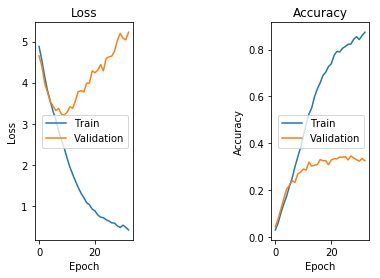

In [148]:
# Visualising Loss and Accuracy
plt.subplot(1,3,1)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['Train', 'Validation'])

plt.subplot(1,3,3)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.legend(['Train', 'Validation'])
plt.show()

In [149]:
predXTrain = modelCNN.predict_classes(XTrain)
predXTest = modelCNN.predict_classes(XTest)

In [165]:
print(classification_report(predXTrain,YTrain))

              precision    recall  f1-score   support

           0       0.26      0.89      0.40         9
           1       0.59      0.59      0.59        79
           2       0.59      0.36      0.45        64
           3       0.62      0.84      0.71        37
           4       0.53      0.57      0.55        44
           5       0.59      0.30      0.39        98
           6       0.42      0.76      0.54        21
           7       0.67      0.91      0.77        32
           8       0.81      0.52      0.63        83
           9       0.81      0.75      0.78       153
          10       0.57      0.69      0.62        48
          11       0.55      0.79      0.65        28
          12       0.31      0.74      0.44        19
          13       0.45      0.87      0.60        23
          14       0.84      0.49      0.62       282
          15       0.55      0.56      0.55        52
          16       0.17      0.30      0.22        20
          17       0.87    

### Conclusion

#### - F1-Score (Without Overfitting)
        For Training Data = 49% for whole dataset and 94% for small part of dataset (for 3 pokemons)
        For Testing Data = 26% for whole dataset and 89% for small part of dataset (for 3 pokemons)
#### - F1-Score (With Overfitting)
        For Training Data = 83.5% for whole dataset
        For Testing Data = 30% for whole dataset